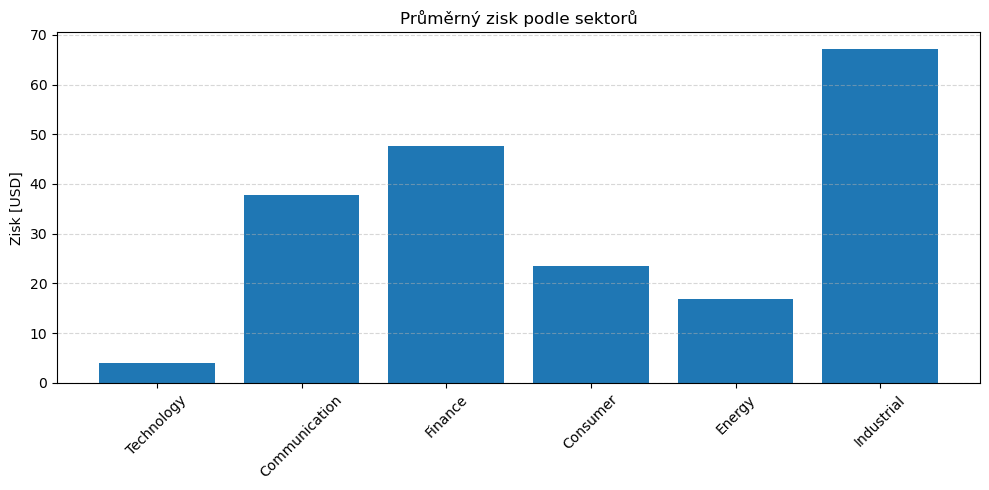


🏆 Top 5 nejvýkonnějších firem:
UNP (Industrial): 198.65 USD
GOOGL (Communication): 113.03 USD
GS (Finance): 85.90 USD
XOM (Energy): 36.39 USD
PG (Consumer): 35.59 USD


In [2]:
# Tento notebook slouží k vyhodnocení výsledků napříč firmami a sektory – analyzuje průměrné zisky, hledá nejvýkonnější sektory a vykresluje přehledné grafy.

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

# Cesta ke složce scripts
sys.path.insert(0, os.path.abspath("../scripts"))

from prepare_data import load_datasets
from lstm_model import get_model
from utils import TimeSeriesDataset

import torch
from torch import nn
from torch.utils.data import DataLoader

# Parametry
DEVICE = "cpu"
EPOCHS = 50
LR = 0.01
BATCH_SIZE = 32

# Načtení dat
datasets = load_datasets()
results = []

for data in datasets:
    x_train = data["x_train"]
    y_train = data["y_train"]
    x_val = data["x_val"]
    y_val = data["y_val"]
    normalizer = data["normalizer"]

    train_ds = TimeSeriesDataset(x_train, y_train)
    val_ds = TimeSeriesDataset(x_val, y_val)
    train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(TimeSeriesDataset(x_val, y_val), batch_size=BATCH_SIZE)

    model = get_model().to(DEVICE)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    for epoch in range(EPOCHS):
        model.train()
        for xb, yb in train_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()

    # Predikce
    model.eval()
    preds = []
    with torch.no_grad():
        for xb, _ in val_dl:
            xb = xb.to(DEVICE)
            out = model(xb).cpu().numpy()
            preds.extend(out)

    pred_prices = normalizer.inverse_transform(np.array(preds))
    true_prices = normalizer.inverse_transform(y_val)

    profits = []
    for today, pred, tomorrow in zip(true_prices[:-1], pred_prices[:-1], true_prices[1:]):
        if pred > today:
            profits.append(tomorrow - today)
        else:
            profits.append(0)

    cumulative = np.cumsum(profits)
    avg_profit = np.mean(profits)

    results.append({
        "sector": data["sector"],
        "ticker": data["ticker"],
        "total_profit": cumulative[-1],
        "avg_profit": avg_profit
    })

# Průměrné zisky podle sektorů
sector_summary = defaultdict(list)
for r in results:
    sector_summary[r["sector"]].append(r["total_profit"])

sector_avg = {s: np.mean(p) for s, p in sector_summary.items()}

# Sloupcový graf sektorů
plt.figure(figsize=(10,5))
plt.bar(sector_avg.keys(), sector_avg.values())
plt.title("Průměrný zisk podle sektorů")
plt.ylabel("Zisk [USD]")
plt.xticks(rotation=45)
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("../results/sector_profit_summary.pdf")  # Export do PDF
plt.show()

# Nejziskovější firmy
top_firms = sorted(results, key=lambda x: x["total_profit"], reverse=True)[:5]
print("\n🏆 Top 5 nejvýkonnějších firem:")
for r in top_firms:
    print(f"{r['ticker']} ({r['sector']}): {r['total_profit']:.2f} USD")

# Export všech výsledků do CSV
df_results = pd.DataFrame(results)
df_results.to_csv("../results/final_results.csv", index=False)
